In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from itertools import combinations
from sklearn.cluster import SpectralClustering

sns.set_theme()

def read_df(path):
    return pd.read_csv(path, sep="\t", compression="gzip", na_values="\\N")

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Movies dataset

In [3]:
# Load datasets
ratings = read_df("title.ratings.tsv.gz")
basics = read_df("title.basics.tsv.gz")
# Only keep movies
df = pd.merge(ratings, basics, on="tconst")
df_movies = df[df['titleType']=='movie']
df_movies.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
339,tt0000502,4.5,14,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100.0,NaN
373,tt0000574,6.0,758,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70.0,"Action,Adventure,Biography"
382,tt0000591,4.6,17,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90.0,Drama
397,tt0000615,4.5,23,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,NaN,NaN,Drama
405,tt0000630,3.8,24,movie,Hamlet,Amleto,0.0,1908.0,NaN,NaN,Drama


In [4]:
print(f"There are %d movies in the dataset." % len(df_movies))

There are 276810 movies in the dataset.


In [5]:
# Separate the genres into categories
dummies = pd.get_dummies(df_movies['genres'])
genres = [c for c in dummies.columns if ',' not in c]
for col in genres:
    df_movies[col] = dummies[[c for c in dummies.columns if col in c]].sum(axis=1)
df_movies.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
339,tt0000502,4.5,14,movie,Bohemios,Bohemios,0.0,1905.0,NaN,100.0,...,0,0,0,0,0,0,0,0,0,0
373,tt0000574,6.0,758,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0.0,1906.0,NaN,70.0,...,0,0,0,0,0,0,0,0,0,0
382,tt0000591,4.6,17,movie,The Prodigal Son,L'enfant prodigue,0.0,1907.0,NaN,90.0,...,0,0,0,0,0,0,0,0,0,0
397,tt0000615,4.5,23,movie,Robbery Under Arms,Robbery Under Arms,0.0,1907.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
405,tt0000630,3.8,24,movie,Hamlet,Amleto,0.0,1908.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


Here we are interested in the average rating and number of votes of the movies and also their genres and year they came out.

In [6]:
df_movies.describe()

,averageRating,numVotes,isAdult,startYear,endYear,Action,Adult,Adventure,Animation,Biography,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
count,276810.000000,2.768100e+05,276810.000000,276779.000000,0.0,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,...,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000,276810.000000
mean,6.145882,3.481787e+03,0.016694,1993.319273,NaN,0.103436,0.015754,0.062801,0.017189,0.030411,...,0.037408,0.002363,0.000166,0.111105,0.023702,0.011918,0.000036,0.081908,0.021426,0.018280
std,1.343272,3.373317e+04,0.128122,25.720192,NaN,0.304527,0.124524,0.242605,0.129974,0.171715,...,0.189761,0.048550,0.012890,0.314263,0.152120,0.108517,0.006010,0.274225,0.144801,0.133961
min,1.000000,5.000000e+00,0.000000,1896.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.300000,1.800000e+01,0.000000,1977.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.300000,5.700000e+01,0.000000,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.100000,2.950000e+02,0.000000,2014.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,2.569002e+06,1.000000,2022.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_movies["logNumVotes"] = np.log(df_movies["numVotes"])

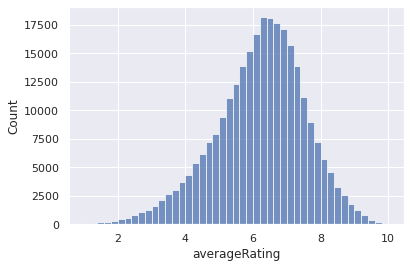

In [8]:
# How are the ratings distributed
sns.histplot(data=df_movies, x="averageRating", binwidth=0.20);

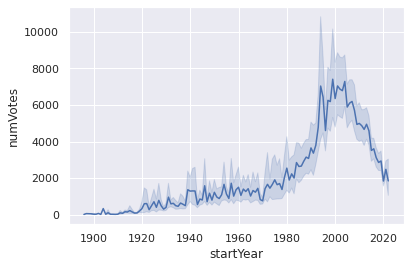

In [9]:
# Do newer movies receive more ratings ? 
sns.lineplot(data=df_movies, x="startYear", y="numVotes");

In [10]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
df_movies["genres"].apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

339             None
373           Action
373        Adventure
373        Biography
382            Drama
             ...    
1230936    Adventure
1230936      History
1230936          War
1230940        Drama
1230949         None
Name: genres, Length: 474772, dtype: object

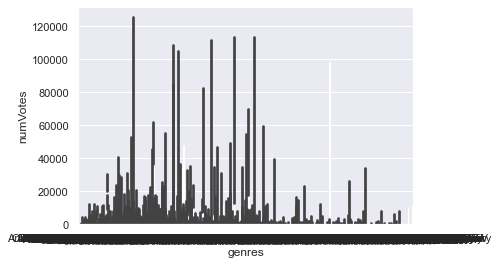

In [7]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
sns.barplot(data=df_movies.explode("genres"), x="genres", y="numVotes");

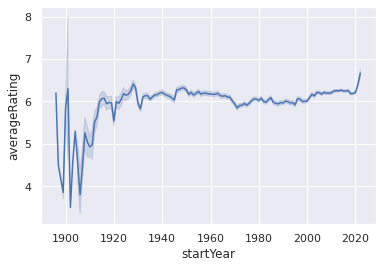

In [11]:
sns.lineplot(data=df_movies, x="startYear", y="averageRating");
# Important question: the increase of the average rating is due to real
# improvement of the movies or are we biased to give a better rating to
# what is more recent 

### Actors dataset

Here we are mostly interested in the actors, and eventually directors. The attribute "knownForTitle" will be used to link the actors together.

In [12]:
actors = pd.read_csv("name.basics.tsv.gz", sep="\t", compression="gzip", na_values = "\\N", nrows = 5000)
actors.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0050419,tt0072308,tt0053137"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0037382,tt0071877,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0057345,tt0056404,tt0049189,tt0054452"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0069467,tt0060827,tt0083922,tt0050986"


In [13]:
exploded_titles = actors.knownForTitles.apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

In [14]:
actors = actors.join(exploded_titles, rsuffix="_ex")

In [15]:
G_actors = nx.Graph()
G_actors.add_nodes_from(actors["primaryName"])

In [16]:
actors.groupby("knownForTitles_ex").primaryName.apply(lambda group: G_actors.add_edges_from(combinations(group, 2)));

Graph with 4947 nodes and 22168 edges


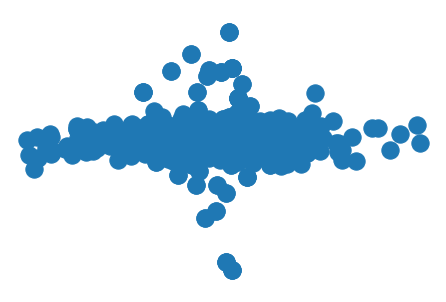

In [17]:
print(nx.info(G_actors))
nx.draw_spectral(G_actors)
# adj_mat = nx.to_numpy_matrix(G_actors)

# spectral_clustering = SpectralClustering(10, affinity="precomputed").fit(adj_mat)